In [1]:
import warnings
warnings.filterwarnings('ignore')
import torch
import tensorflow as tf
import numpy as np
import cv2
from craft_text_detector import (
    load_craftnet_model,
    load_refinenet_model,
    get_prediction,
    export_detected_regions,
    export_extra_results,
    empty_cuda_cache
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import pytesseract
from PIL import Image
from craft_text_detector import Craft 
import glob
from random import choice

%matplotlib inline

2022-12-11 11:26:07.814545: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-11 11:26:08.133878: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-11 11:26:08.804691: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64
2022-12-11 11:26:08.804768: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: can

In [2]:
tf.config.get_visible_devices()

2022-12-11 11:26:10.586443: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 11:26:10.677809: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 11:26:10.678447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## __Modelos entrenados a usar__

In [3]:
modelo_yolo = torch.hub.load('Extracion_texto_doc/YoloModel/yolov5/','custom',path='Extracion_texto_doc/YoloModel/mi_modelo/weights/best.pt', source='local') 
modelo_DE = tf.keras.models.load_model('Extracion_texto_doc/DeepEraseModel/my_model_2/')
modelo_DE_RES_l = tf.keras.models.load_model('Extracion_texto_doc/DeepEraseModel/my_model_3Restauracion/')
modelo_DE_RES_n = tf.keras.models.load_model('Extracion_texto_doc/DeepEraseModel/my_model_4Restauracion/')
refine_net = load_refinenet_model()
craft_net = load_craftnet_model()

YOLOv5 🚀 v6.2-183-gc98128f Python-3.8.10 torch-1.12.1+cu102 CUDA:0 (Quadro RTX 5000 with Max-Q Design, 16125MiB)

Fusing layers... 
YOLOv5x summary: 322 layers, 86193601 parameters, 0 gradients, 203.8 GFLOPs
Adding AutoShape... 
2022-12-11 11:26:15.611390: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-11 11:26:15.612172: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 11:26:15.612328: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA

## __Seleccionamos expediente al azar__

In [117]:
documentos = glob.glob('/home/victor-cimat/tesis/YOLO/Ext-HOJAS-AMARILLAS-5/valid/images/*')
documentos = glob.glob('/home/victor-cimat/tesis/Pipeline_final/img_prueba/*')

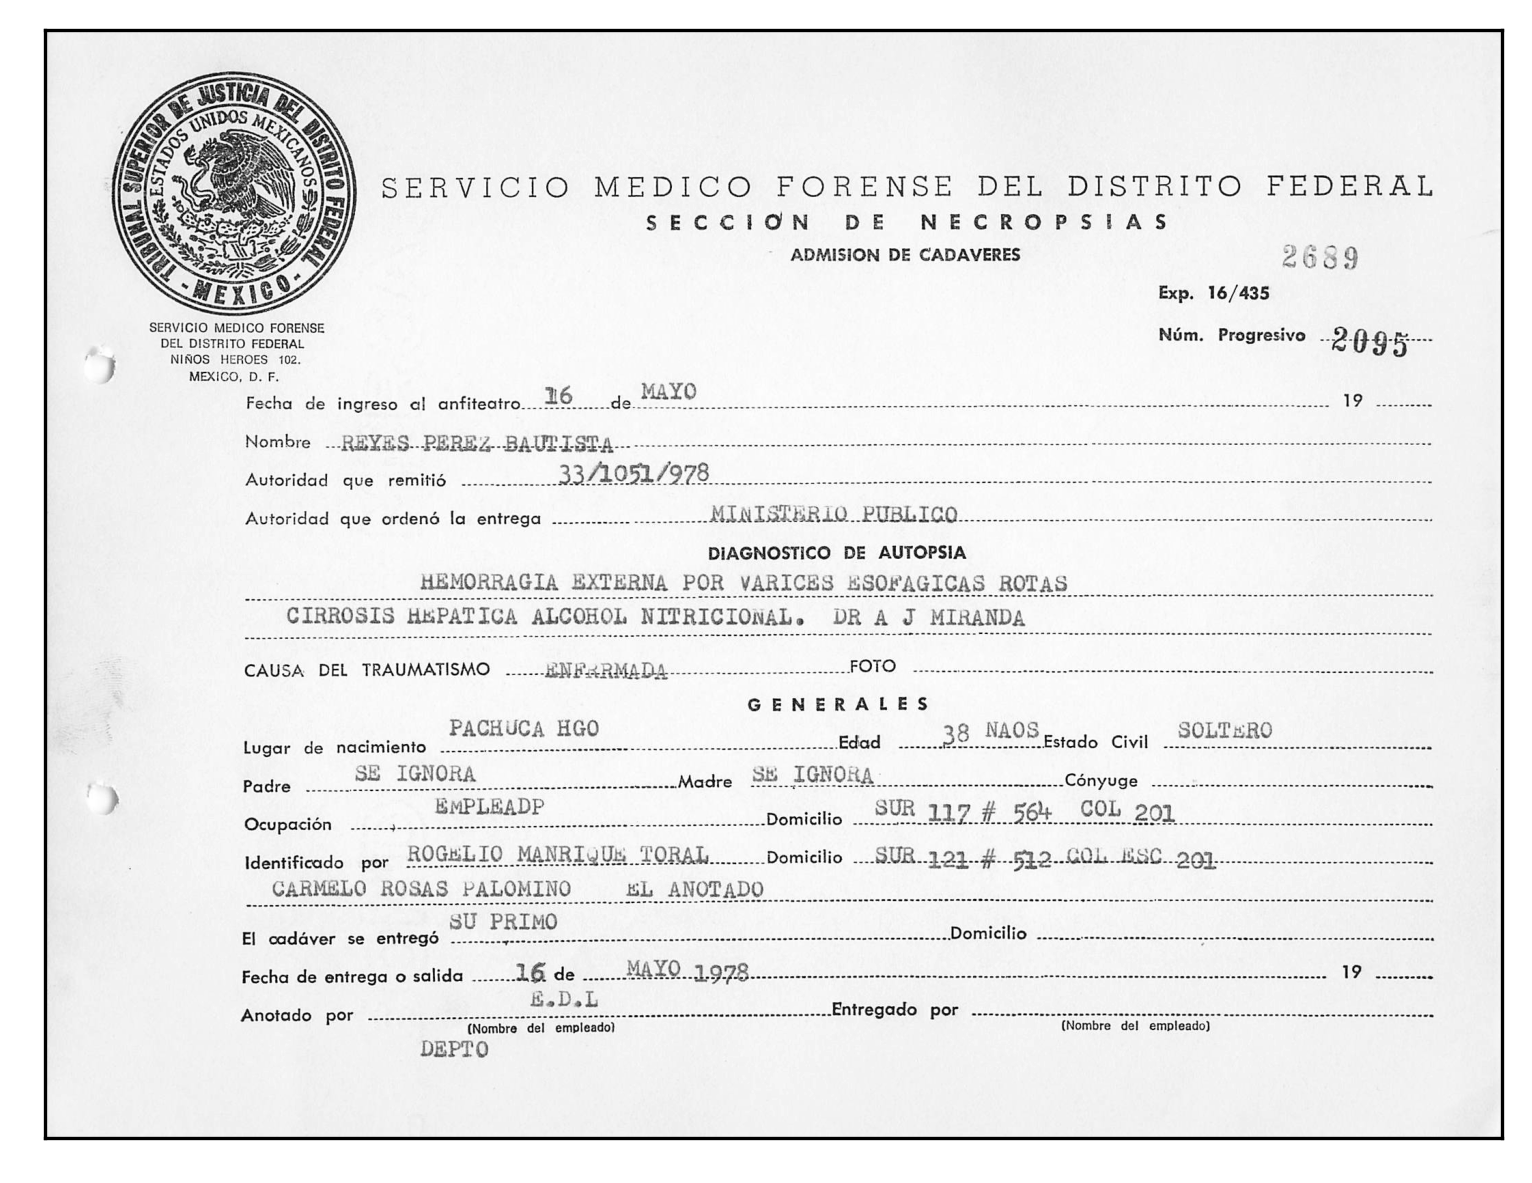

In [133]:
imagen = choice(documentos)
imagen_r = cv2.imread(imagen)
imagen_r = cv2.cvtColor(imagen_r, cv2.COLOR_BGR2GRAY)
#cv2.imwrite(imagen,imagen_r)

%matplotlib inline

fig = plt.figure(dpi=300)
plt.imshow(imagen_r,cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

## __Identificación y extracción de regiones en el documento__

In [134]:
documento_marcado = modelo_yolo(imagen, augment=True)

In [135]:
recortes = [imgCrop['im'] 
            for imgCrop in documento_marcado.crop(save=False) 
            if imgCrop['conf'] > 0.7 ]
etiquetas = [imgCrop['label'][:len(imgCrop['label'])-5] 
             for imgCrop in documento_marcado.crop(save=False) 
             if imgCrop['conf'] > 0.7 ]

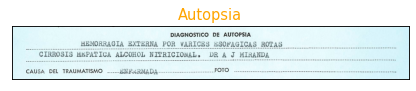

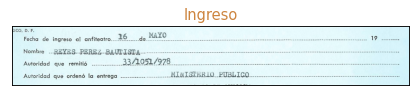

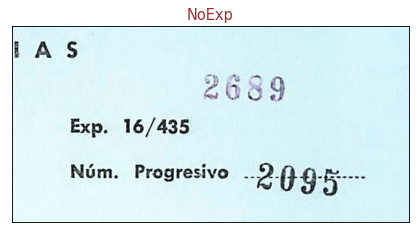

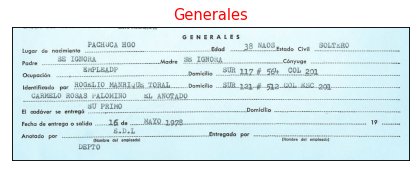

In [136]:
colores = ['orange','peru','brown','red']
for i, imgCrop in enumerate(recortes):
    fig = plt.figure(dpi=80)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imgCrop,cmap='gray')
    plt.title(etiquetas[i],color=colores[i])
    plt.show()

## __Tomamos una sección para extraer el texto__

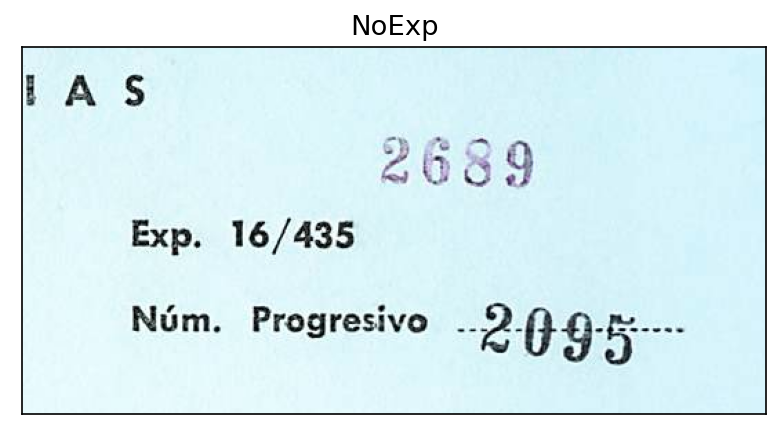

In [156]:
idRec = 2
fig = plt.figure( dpi=150)
plt.imshow(recortes[idRec],cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title(etiquetas[idRec])
plt.show()

## __Recorte de la imagne en palabras__

In [157]:
output_dir = 'output/'

# create a craft instance
craft = Craft(output_dir=output_dir, crop_type="poly", cuda=False)

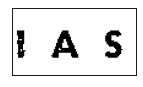

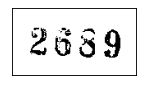

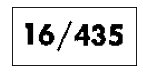

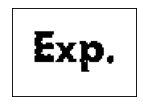

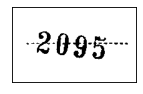

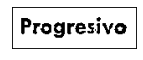

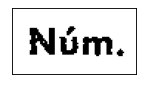

In [160]:
recortes_bi = []
for rec in recortes:
    bw = cv2.cvtColor(rec, cv2.COLOR_BGR2GRAY)
    recortes_bi.append(255-bw)

if etiquetas[idRec] == 'NoExp':
    prediction_result = get_prediction(
                            image=recortes_bi[idRec],
                            craft_net=craft_net,
                            refine_net=refine_net,
                            text_threshold=0.1,
                            link_threshold=0.4,
                            low_text=0.01,
                            cuda=False,
                            long_size=2000)
    
else:
    prediction_result = craft.detect_text(recortes_bi[idRec])

recortes_dir = 'output/image_crops/'
!rm -r $recortes_dir
palabras = export_detected_regions(
    image=recortes_bi[idRec],
    regions=prediction_result["boxes"])

for img in palabras:
    imagen = 255-cv2.imread(img,0)
    #blur = cv2.GaussianBlur(imagen,(5,5),0)
    th, imagen = cv2.threshold(imagen,0,255,cv2.THRESH_OTSU)
    #th, imagen = cv2.threshold(imagen, 0, 255, cv2.THRESH_OTSU)
    #imagen = np.where(imagen>np.mean(imagen), 255, 0)
    aumentar_v = np.ones((1,imagen.shape[1]))*np.max(imagen)
    imagen = np.vstack([aumentar_v, imagen, aumentar_v])
    aumentar_h = np.ones((imagen.shape[0],1))*np.max(imagen)
    imagen = np.hstack([aumentar_h, imagen, aumentar_h])
    cv2.imwrite(img,imagen)
    
    fig = plt.figure(figsize=(2, 3), dpi=80)
    plt.imshow(imagen,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
puntos = prediction_result['boxes'][:,0]
palabras_inc = palabras.copy()


## __Ordenamos los recortes__

In [161]:
palabras_inc = [palabras_inc[i] for i in puntos[:,0].argsort()]
puntos = puntos[puntos[:,0].argsort()]

In [162]:
dimens = (np.min(prediction_result['boxes'][:,0,1]),np.max(prediction_result['boxes'][:,3,1]))

In [163]:
row_amp = np.median(prediction_result['boxes'][:,2,1]-prediction_result['boxes'][:,0,1])
row_amp_std = np.std(prediction_result['boxes'][:,2,1]-prediction_result['boxes'][:,0,1])

In [164]:
rangos = np.arange(dimens[0],dimens[1]-dimens[0],row_amp+row_amp_std)

In [165]:
orden = []
for i in range(len(rangos)-1):
    pintos_in = []
    row_id = []
    for j, p in enumerate(puntos[:,1]):
        if rangos[i]<= p and p < rangos[i+1]:
            pintos_in.append(puntos[:,0][j])
            row_id.append(j)
    pintos_in = np.argsort(np.array(pintos_in))
    orden = orden +  [row_id[k] for k in pintos_in]
orden = np.array(orden)

In [166]:
palab_orde = [palabras_inc[i] for i in orden]

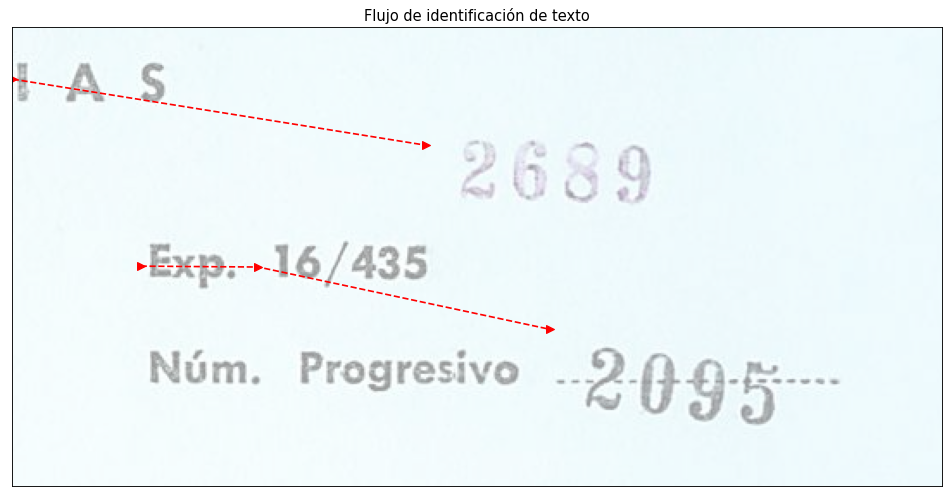

In [167]:
fig = plt.figure(figsize=(15, 10), dpi=80)
plt.imshow(recortes[idRec],cmap='gray',alpha=0.4)
punto_orde =  puntos[orden]
for i in range(len(rangos)-1):
    p_r = punto_orde[(rangos[i]<=punto_orde[:,1])&(punto_orde[:,1] < rangos[i+1])]
    plt.plot(p_r[:,0],
            p_r[:,1]+row_amp/2,'r--')
    plt.scatter(p_r[:,0],
            p_r[:,1]+row_amp/2,c='r',s=50,marker =">")
plt.xticks([])
plt.yticks([])
plt.title('Flujo de identificación de texto')
plt.show()

## __Extraemos el texto de cada recorte__

1/1 [==============================] - 0s 22ms/step


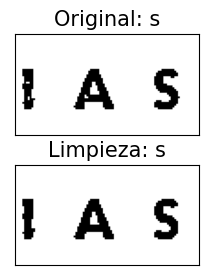

1/1 [==============================] - 0s 20ms/step


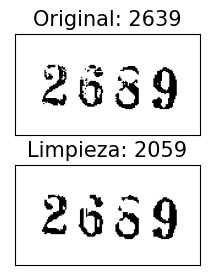

1/1 [==============================] - 0s 20ms/step


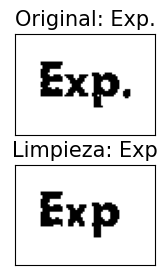

1/1 [==============================] - 0s 20ms/step


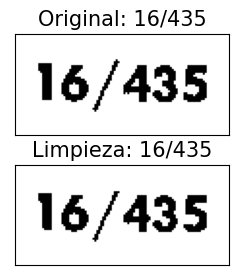

1/1 [==============================] - 0s 20ms/step


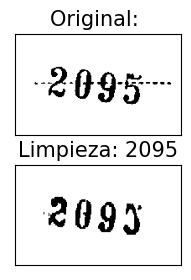

In [168]:
texto_extraccion = []
for ImPaRePath in palab_orde:
    imagen = cv2.imread(ImPaRePath,0)

    
    custom_config = r'--oem 3 --psm 6'
    txt1 = pytesseract.image_to_string(imagen, lang='spa', config=custom_config)
    
    cond1 = True
    
    if cond1:
        
        imgPalRec = tf.io.read_file(ImPaRePath)
        imgPalRec = tf.image.decode_jpeg(imgPalRec, channels=1)
        imgPalRec = tf.image.resize(imgPalRec, (64,512))
        imgPalRec = tf.image.convert_image_dtype(imgPalRec, tf.float32)/255
        imgPalRec = tf.data.Dataset.from_tensors(imgPalRec[None,:,:,:])
        
        
        imgPalRecPre = modelo_DE.predict(imgPalRec)
        imgPalRecPre = modelo_DE_RES_l.predict(imgPalRecPre)
        img_pred =  cv2.resize(imgPalRecPre[0][:,:,0],
                               (imagen.shape[1],imagen.shape[0]),
                               interpolation = cv2.INTER_AREA)
        
        img_pred[img_pred<=(np.median(img_pred)-2*np.std(img_pred))] = 0
        img_pred[img_pred >(np.median(img_pred)-2*np.std(img_pred))] = 255
        img_pred = np.array(img_pred, dtype=np.uint8)


        if etiquetas[idRec] == 'NoExp':
            custom_config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=Exp/.NumProgresivo0123456789'
            txt1 = pytesseract.image_to_string(imagen, lang='spa', config=custom_config)
            txt2 = pytesseract.image_to_string(img_pred, lang='spa', config=custom_config)
        else:
            custom_config = r'--oem 3 --psm 6'
            txt1 = pytesseract.image_to_string(imagen, lang='spa', config=custom_config)
            txt2 = pytesseract.image_to_string(img_pred, lang='spa', config=custom_config)
            texto_extraccion.append((txt1[:-2],txt2[:-2]))
            
        
        fig = plt.figure(figsize=(8, 3), dpi=100)
        gs = fig.add_gridspec(2, hspace=0.3)
        axs = gs.subplots(sharex=True, sharey=True)
        axs[0].imshow(imagen,cmap='gray')
        axs[0].get_xaxis().set_visible(False)
        axs[0].get_yaxis().set_visible(False)
        axs[0].set_title('Original: '+txt1[:-2],fontsize=15)
        axs[1].imshow(img_pred,cmap='gray')
        axs[1].get_xaxis().set_visible(False)
        axs[1].get_yaxis().set_visible(False)
        axs[1].set_title('Limpieza: '+txt2[:-2],fontsize=15)
        plt.show()
    